In [1]:
import os, sys

import pymongo as pm
import base64
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import socket
import io

from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%load_ext autoreload
%autoreload 2

### Directory & file hierarchy

In [2]:

proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
[make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

['/Users/kushinm/Documents/Github/things-drawings/results',
 '/Users/kushinm/Documents/Github/things-drawings/results/plots',
 '/Users/kushinm/Documents/Github/things-drawings/results/csv']

### Quick helpers

In [3]:
## transsform base64 png string to image for plotting
def string_to_image(im_string):
    im = io.BytesIO(base64.decodebytes(str.encode(im_string.split(',')[1])))
    im = mpimg.imread(im, format='PNG')
    return im


### function to plot a grid of sketches

def plot_image_grid(concept,dim):

    im_arr = sketch_df[sketch_df.concept==concept].png_array
    if im_arr.shape[0]<dim:
        dim = im_arr.shape[0]
    
    fig = plt.figure(figsize=(dim*1.5, 2))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(1, dim),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes
                    )

    for ax, im in zip(grid, im_arr):
        ax.imshow(im)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
    fig.suptitle(f'THINGS-100 {concept}', fontsize=16)


    plt.show()


### Set up connetion to mongo
#### Ignore the next few cells if loading data locally and go the 'Load data locally' part of the notebook
Don't forget to `ssh -fNL 27017:127.0.0.1:27017` \
auth.txt should be in your local repository

In [77]:
PROJECT = "things-drawings"
# DATASET = "things-100" ## this was our pilot run
DATASET = "things-1854"
TASK = "production_run_patching"
ITERATION = "pilot_3"
EXPERIMENT = DATASET + "_" + TASK
# EXPERIMENT = DATASET 

In [78]:
### set up credentials

auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn[PROJECT]
coll = db[EXPERIMENT]

In [131]:
d = conn['visual-abstraction-benchmarking']

coll = d['things-128_recognition_human']

In [132]:
### list all collections in d
d.list_collection_names()

['things-128_recognition_human']

In [133]:

print('We have {} records in mongo.'.format(coll.estimated_document_count()))


We have 340 records in mongo.


In [134]:
pd.DataFrame(coll.find({'iterationName':'testing','trial_type':'html-keyboard-response'}))

,_id,rt,stimulus,response,filename_recog,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID,valid
0,642b4ac13515d453359a0f41,1186,<p>Press 'v' if valid or 'i' if invalid. Is th...,v,milkshake_04s_32000_63dd8f7c210faf0f7d158183.png,html-keyboard-response,2,4311,0.0-2.0-0.0,fine,testing,prolific,None,None,None,True
1,642b4ac33515d453359a0f43,1993,<p>Press 'v' if valid or 'i' if invalid. Is th...,i,tortellini_09s_4000_63ce069b8988816856b67f1f.png,html-keyboard-response,3,6305,0.0-2.0-0.1,fine,testing,prolific,None,None,None,False
2,642b4ac53515d453359a0f44,1368,<p>Press 'v' if valid or 'i' if invalid. Is th...,v,beanbag_16s_8000_63cc3827f845c37fbc6fc3b8.png,html-keyboard-response,4,7674,0.0-2.0-0.2,fine,testing,prolific,None,None,None,True
3,642b4ac63515d453359a0f46,1136,<p>Press 'v' if valid or 'i' if invalid. Is th...,i,chainsaw_03s_8000_63cb261cf845c37fbc6fa53f.png,html-keyboard-response,5,8811,0.0-2.0-0.3,fine,testing,prolific,None,None,None,False
4,642b4ac73515d453359a0f47,1063,<p>Press 'v' if valid or 'i' if invalid. Is th...,v,wrap_06s_4000_63cc3846c966b17f84911ec4.png,html-keyboard-response,6,9875,0.0-2.0-0.4,fine,testing,prolific,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,642bb9e0638efd1e1c1fb835,1661,<p>Press <b>v</b> if valid or <b>i</b> if inva...,arrowright,volleyball_12s_32000_63cc58442fd8a27fefec6cc6.png,html-keyboard-response,5,11904,0.0-2.0-0.3,fine,testing,prolific,None,None,None,True
336,642bba0b638efd1e1c1fb836,2519,<p>Press <b>v</b> if valid or <b>i</b> if inva...,arrowright,extinguisher_13s_4000_63cb6d2dc966b17f849119e2...,html-keyboard-response,2,4468,0.0-2.0-0.0,fine,testing,prolific,None,None,None,True
337,642bba0f638efd1e1c1fb837,4391,<p>Press <b>v</b> if valid or <b>i</b> if inva...,arrowright,doily_06s_16000_63cf70a1e16530353f1fd121.png,html-keyboard-response,3,8863,0.0-2.0-0.1,fine,testing,prolific,None,None,None,False
338,642bba11638efd1e1c1fb838,1998,<p>Press <b>v</b> if valid or <b>i</b> if inva...,arrowright,kimono_04s_16000_63cb13f90328517f9fc435a1.png,html-keyboard-response,4,10863,0.0-2.0-0.2,fine,testing,prolific,None,None,None,True


In [104]:
### Check that we have all the columns we want
print(coll.find_one().keys())

dict_keys(['_id', 'rt', 'stimulus', 'response', 'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id', 'pointer_device', 'iterationName', 'recruitmentPlatform', 'workerID', 'studyID', 'sessionID'])


In [69]:
### Make a df of sketches and metadata
coll_filtered = coll.find({'iterationName':ITERATION,'trial_type':'sketchpad'})
#pd.DataFrame(coll_filtered).to_csv(os.path.join(csv_dir,'temp.csv'))
sketch_df = pd.DataFrame(coll_filtered)
ratings_meta_df = pd.DataFrame(coll.find({'iterationName':ITERATION,'trial_type':'survey-multi-choice'}))
ratings_meta_df = ratings_meta_df.loc[ratings_meta_df['trial_index'] != 50]

survey_df = pd.DataFrame(coll.find({'trial_type': {'$ne': 'sketchpad'}}))
survey_df = survey_df.loc[(survey_df['trial_index'] == 50) | \
              (survey_df['trial_index'] == 51) | \
              (survey_df['trial_index'] == 52) | \
              (survey_df['trial_index'] == 53)]

survey_df.to_csv(os.path.join(csv_dir,'things_drawing_1854_{}_demosurvey.csv'.format(ITERATION)))
ratings_meta_df.to_csv(os.path.join(csv_dir,'things_drawing_1854_{}_meta.csv'.format(ITERATION)))
sketch_df.to_csv(os.path.join(csv_dir,'things_drawing_1854_{}_sketches.csv'.format(ITERATION)))

### Load data locally: Put CSVs in '../results/csv/'

In [237]:
sketch_df = pd.read_csv(os.path.join(csv_dir,'things_drawing_1854_{}_sketches.csv'.format(ITERATION)))
ratings_meta_df = pd.read_csv(os.path.join(csv_dir,'things_drawing_1854_{}_meta.csv'.format(ITERATION)))

sketch_df.strokes = sketch_df.apply(lambda x: eval(x.strokes), axis=1)
sketch_df.undo_history = sketch_df.apply(lambda x: eval(x.undo_history), axis=1)

In [238]:
# sketch_df.workerID.nunique()
sketch_df.gameID.nunique()

6

In [70]:
### We'll want to save images based on sessionID
### Save the images in the 'plots' dir
iteration_dir = os.path.join(plot_dir,EXPERIMENT+'_'+ITERATION)
make_dir_if_not_exists(iteration_dir)


for i, row in sketch_df.iterrows():
    with open(os.path.join(iteration_dir,f"{row.concept}_{row.sessionID}.png"), "wb") as fw:
        fw.write(base64.decodebytes(str.encode(row.png.split(',')[1])))
        


### Let's visualize a few sketches

In [10]:
##Cherry picked sketch
test_strokes = sketch_df.strokes[3] 
test_undos = sketch_df.undo_history[3] ### Might not exist


In [11]:
### Old plotting code, keep around if needed

# im_temp = np.zeros((550,550))

# for stroke in test_strokes:

#     xs = [x['x'] for x in stroke if x['action']!='end']
#     ys = [x['y'] for x in stroke if x['action']!='end']
#     im_temp[ys,xs]=1
# plt.imshow(im_temp, cmap = 'gray_r')
# plt.title('pen trajectory')
# plt.show()

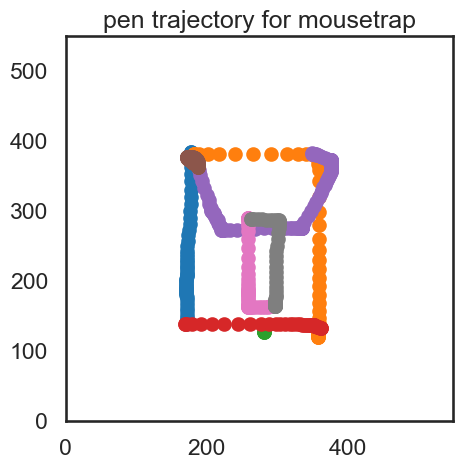

In [13]:
plt.figure(figsize=(5,5))

for stroke in test_strokes:

    xs = [x['x'] for x in stroke if x['action']!='end']
    ys = [x['y'] for x in stroke if x['action']!='end']
    plt.scatter(np.array(xs),550-np.array(ys))
plt.xlim(0,550)
plt.ylim(0,550)
plt.title(f'pen trajectory for {sketch_df.concept[3]}'  )
plt.show()

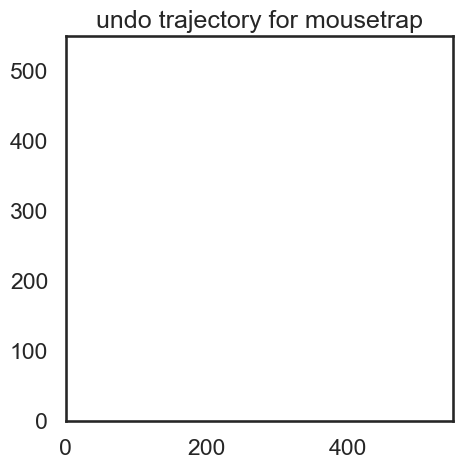

In [14]:
plt.figure(figsize=(5,5))

for stroke in test_undos:

    xs = [x['x'] for x in stroke if x['action']!='end']
    ys = [x['y'] for x in stroke if x['action']!='end']
    plt.scatter(np.array(xs),550-np.array(ys))
plt.xlim(0,550)
plt.ylim(0,550)
plt.title(f'undo trajectory for {sketch_df.concept[3]}' )
plt.show()


### Get a snapshot of both dfs

In [25]:
sketch_df.shape

(114, 19)

In [16]:
ratings_meta_df['concept']

0             bow2
1             gear
2           violin
3         lunchbox
4      sarcophagus
          ...     
127          spout
128           milk
129           lamb
130       piecrust
131          crank
Name: concept, Length: 128, dtype: object

In [17]:
sketch_df.head()

,_id,rt,response,concept,gameID,prompt,undo_history,png,strokes,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID
0,6418a0b288da294e33e75e64,11682,button,bow2,8114-87673960-5c09-42af-8f72-680562e600e6,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 310, 'y': 39, 'color': '#000000', 'act...",sketchpad,2,18442,0.0-2.0-0.0,fine,pilot_1,prolific,5efceb0f4a5f9f1079fbd048,6418a021aa930a2c4f89e031,6418a08fcbb7243a71762cf1
1,6418a0e088da294e33e75e66,42824,button,gear,8114-87673960-5c09-42af-8f72-680562e600e6,<p style='font-size:25px;font-weight:bold;marg...,"[[{'x': 246, 'y': 211, 'color': '#000000', 'ac...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 265, 'y': 76, 'color': '#000000', 'act...",sketchpad,4,64605,0.0-2.0-0.1,fine,pilot_1,prolific,5efceb0f4a5f9f1079fbd048,6418a021aa930a2c4f89e031,6418a08fcbb7243a71762cf1
2,6418a17688da294e33e75e69,19593,button,lunchbox,8114-87673960-5c09-42af-8f72-680562e600e6,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 104, 'y': 159, 'color': '#000000', 'ac...",sketchpad,8,215289,0.0-2.0-0.3,fine,pilot_1,prolific,5efceb0f4a5f9f1079fbd048,6418a021aa930a2c4f89e031,6418a08fcbb7243a71762cf1
3,6418a1ef88da294e33e75e6c,26042,button,mousetrap,8114-87673960-5c09-42af-8f72-680562e600e6,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 178, 'y': 166, 'color': '#000000', 'ac...",sketchpad,12,335453,0.0-2.0-0.5,fine,pilot_1,prolific,5efceb0f4a5f9f1079fbd048,6418a021aa930a2c4f89e031,6418a08fcbb7243a71762cf1
4,6418a20388da294e33e75e6e,18808,button,rattle,8114-87673960-5c09-42af-8f72-680562e600e6,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 205, 'y': 65, 'color': '#000000', 'act...",sketchpad,14,356153,0.0-2.0-0.6,fine,pilot_1,prolific,5efceb0f4a5f9f1079fbd048,6418a021aa930a2c4f89e031,6418a08fcbb7243a71762cf1


In [18]:
sketch_df['concept']

0           bow2
1           gear
2       lunchbox
3      mousetrap
4         rattle
         ...    
109        spout
110         milk
111         lamb
112     piecrust
113        crank
Name: concept, Length: 114, dtype: object

In [19]:
sorted(sketch_df['concept']) == sorted(ratings_meta_df['concept'])

False

In [20]:
list1 = list(sorted(ratings_meta_df['concept']))
len(list1)

128

In [21]:
list2 = list(sorted(sketch_df['concept']))
len(list2)

114

In [260]:
(set(list1).difference(list2))

{'breakfast',
 'caterpillar',
 'cougar',
 'eyedropper',
 'lumber',
 'sarcophagus',
 'sauerkraut',
 'scanner',
 'seaweed',
 'space_shuttle',
 'speedometer',
 'telephone_pole',
 'toilet_paper',
 'violin'}

## ☢️ Careful here ☢️

In [91]:
# really_run=False
# if really_run==True:
#     db.drop_collection('things-1854_production_run')